In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path/ "food_data"

# if the image folder doesn't exist, download it prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path/"food_data.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the data!")
    f.write(request.content)

  # Unzip pizza, steak and sushi data
  with zipfile.ZipFile(data_path / "food_data.zip", 'r') as zip_ref:
    print("Unzipping the data...")
    zip_ref.extractall(image_path)

data/food_data directory exists.


In [ ]:
#setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"


In [ ]:
train_dir, test_dir

(PosixPath('data/food_data/train'), PosixPath('data/food_data/test'))

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Loading Image Data using ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")


Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/food_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/food_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             shuffle=False)

In [ ]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d068499c4d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d0685db6190>)

In [ ]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                       stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                       stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x)
    return x

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=3)

In [ ]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=3, bias=True)
  )
)

In [ ]:
img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]

model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single)

print(f"output logits: {pred}")
print(f"Output pred prob: {torch.softmax(pred, dim=1)}")
print(f"output prob: {torch.argmax(torch.softmax(pred, dim=1))}")
print(f"Actual label: {label_single}")

output logits: tensor([[0.0088, 0.0170, 0.0246]])
Output pred prob: tensor([[0.3307, 0.3334, 0.3359]])
output prob: 2
Actual label: 2


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 10, 224, 224]         280
│    └─ReLU: 2-2                         [1, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 10, 224, 224]         910
│    └─ReLU: 2-4                         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 10, 112, 112]         910
│    └─ReLU: 2-7                         [1, 10, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 10, 56, 56]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flatten: 2-9                      [1, 31360]                --
│    └─Linea

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader:  torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 50):
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

In [ ]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=3)

loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

end_time = timer()
print(f"Total time taken: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1644 | train_acc: 0.3644 | test_loss: 1.0780 | test_acc: 0.4267
Epoch: 2 | train_loss: 1.0082 | train_acc: 0.5067 | test_loss: 1.0950 | test_acc: 0.3733
Epoch: 3 | train_loss: 0.9294 | train_acc: 0.5867 | test_loss: 0.9921 | test_acc: 0.4667
Epoch: 4 | train_loss: 0.8302 | train_acc: 0.6489 | test_loss: 1.0170 | test_acc: 0.4400
Epoch: 5 | train_loss: 0.7554 | train_acc: 0.6711 | test_loss: 1.0262 | test_acc: 0.4400
Epoch: 6 | train_loss: 0.7261 | train_acc: 0.7244 | test_loss: 1.0465 | test_acc: 0.4133
Epoch: 7 | train_loss: 0.5242 | train_acc: 0.7956 | test_loss: 1.2114 | test_acc: 0.4667
Epoch: 8 | train_loss: 0.4360 | train_acc: 0.8489 | test_loss: 1.2802 | test_acc: 0.4800
Epoch: 9 | train_loss: 0.2519 | train_acc: 0.9200 | test_loss: 1.5201 | test_acc: 0.4800
Epoch: 10 | train_loss: 0.1547 | train_acc: 0.9467 | test_loss: 1.7302 | test_acc: 0.4933
Epoch: 11 | train_loss: 0.1415 | train_acc: 0.9422 | test_loss: 1.8214 | test_acc: 0.5067
Epoch: 12 | train_l

In [ ]:
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

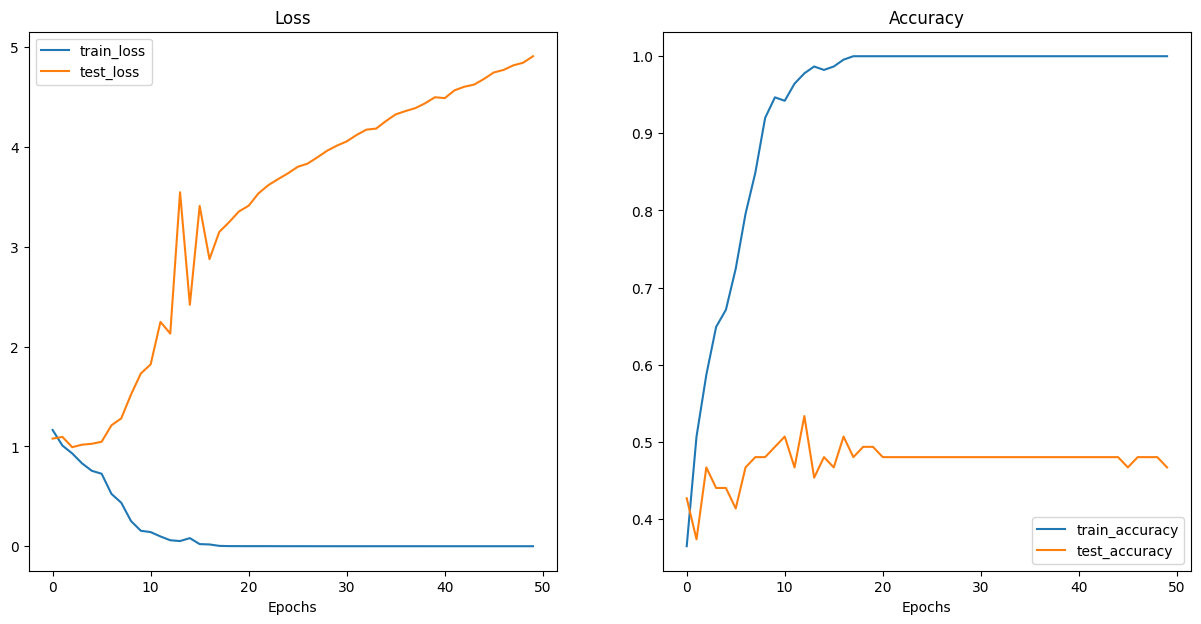

In [ ]:
plot_loss_curves(model_0_results) # Shape resize to 224, 224

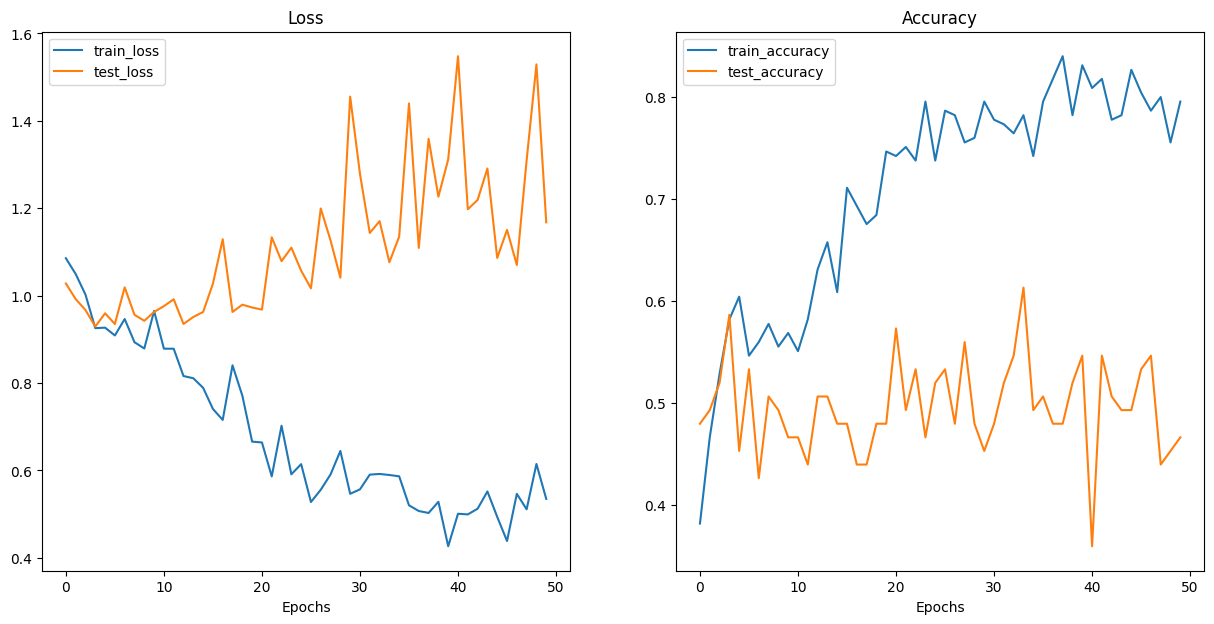

In [ ]:
plot_loss_curves(model_0_results) # Data augmented

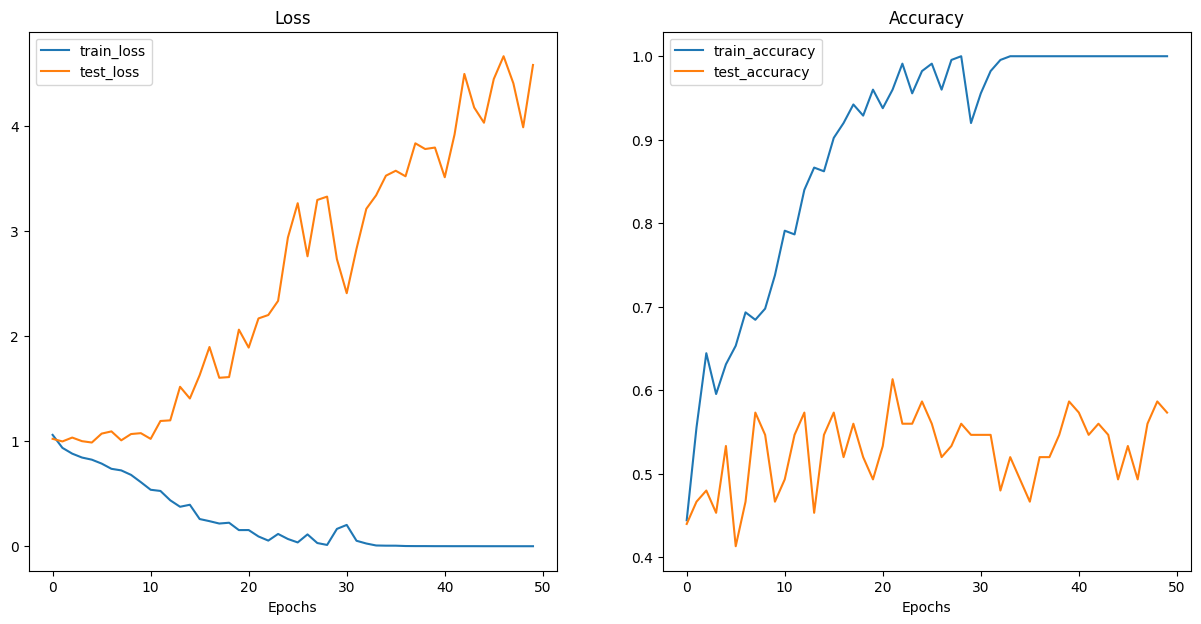

In [ ]:
plot_loss_curves(model_0_results)# Non augmented